In [22]:
import numpy as np
import pandas as p
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, regularizers
import tensorflow_probability as tfp

In [26]:
tfd = tfp.distributions

In [4]:
# GET THE MNIST DATA
(x_train, y_test), (x_test, y_test) = mnist.load_data()


In [5]:
# Function to 
# 1. Change dimensions
# 2. Change datatype
def binary_preprocess(imageset):
    imageset = imageset.reshape(imageset.shape[0],28,28,1)/255.
    return np.where(imageset > .5, 1.0,0.0).astype('float32')

In [6]:
# Pre-processed images 
x_train_images = binary_preprocess(x_train)
x_test_images = binary_preprocess(x_test)

In [7]:
# Dataset object to get a mini-batch
batch_size = 100
train_size = x_train_images.shape[0]

In [139]:
def get_encoder():
  # THE ENCODER DEFINITION
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(2), scale=1.), 
                            reinterpreted_batch_ndims=1)
    input_shape = (28,28,1)
    encoded = tf.keras.models.Sequential(
          [
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256,activation='relu'),
            tf.keras.layers.Dense(tfp.layers.IndependentNormal.params_size(2), 
                                         activation=None, name='z_params'),          
            # No activation
            tfp.layers.IndependentNormal(2, 
                    convert_to_tensor_fn=tfd.Distribution.sample, 
                    activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1), 
                    name='z_layer'),
        ]
    )
    return encoded


# Sequential API decoder

def get_decoder():
    decoded = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(2,)),              
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),            
            tf.keras.layers.Dense(784),
            tfp.layers.IndependentBernoulli((28,28,1), name='x_layer')
        ]
    )

    return decoded

def autoencoder(encoder,decoder):
    x_input = tf.keras.Input(shape=(28,28,1))
    encoder = get_encoder()
    decoder = get_decoder()
    z = encoder(x_input)

    # compile VAE model
    model = tf.keras.Model(inputs=x_input, outputs=decoder(z))
    model.compile(loss=negative_log_likelihood, 
                  optimizer=tf.keras.optimizers.Adam(1e-3))
    return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


In [106]:
def get_encoder():
    # define prior distribution for the code, which is an isotropic Gaussian
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(2), scale=1.), 
                            reinterpreted_batch_ndims=1)
    # build layers argument for tf.keras.Sequential()
    input_shape = (28,28,1)
    layers = [tf.keras.layers.InputLayer(input_shape=input_shape)]
    layers.append(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                              padding='valid', activation='relu'))
    layers.append(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                              padding='valid', activation='relu'))
    layers.append(tf.keras.layers.Flatten())
    # the following two lines set the output to be a probabilistic distribution
    layers.append(tf.keras.layers.Dense(tfp.layers.IndependentNormal.params_size(2), 
                             activation=None, name='z_params'))
    layers.append(tfp.layers.IndependentNormal(2, 
        convert_to_tensor_fn=tfd.Distribution.sample, 
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1), 
        name='z_layer'))
    return tf.keras.Sequential(layers, name='encoder')


def get_decoder():
    layers = [tf.keras.layers.InputLayer(input_shape=2)]
    layers.append(tf.keras.layers.Dense(7*7*32, activation=None))
    layers.append(tf.keras.layers.Reshape((7,7,32)))
    layers.append(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                       padding='same', activation='relu'))
    layers.append(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                       padding='same', activation='relu'))
    layers.append(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                       padding='same'))
    layers.append(tf.keras.layers.Flatten(name='x_params'))
    # note that here we don't need 
    # `tf.keras.layers.Dense(tfp.layers.IndependentBernoulli.params_size(self.dim_x))` because 
    # we've restored the desired input shape with the last Conv2DTranspose layer
    layers.append(tfp.layers.IndependentBernoulli((28,28,1), name='x_layer'))
    return tf.keras.Sequential(layers, name='decoder')


def autoencoder(encoder,decoder):
    x_input = tf.keras.Input(shape=(28,28,1))
    encoder = get_encoder()
    decoder = get_decoder()
    z = encoder(x_input)

    # compile VAE model
    model = tf.keras.Model(inputs=x_input, outputs=decoder(z))
    model.compile(loss=negative_log_likelihood, 
                  optimizer=tf.keras.optimizers.Adam(1e-3))
    return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [140]:
# Instantiate 
harencoder = get_encoder()
hardecoder = get_decoder()
model = autoencoder(harencoder,hardecoder)

In [141]:
model.fit(x_train_images,x_train_images,batch_size=100,epochs=10)

Epoch 1/10
600/600 [==============================] - 3s 3ms/step - loss: 247.7511
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 173.5452
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 168.6867
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 165.8147
Epoch 5/10
600/600 [==============================] - 2s 4ms/step - loss: 163.8519
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 161.8502
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 160.0112
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 158.6994
Epoch 9/10
600/600 [==============================] - 2s 4ms/step - loss: 157.5321
Epoch 10/10
600/600 [==============================] - 3s 5ms/step - loss: 156.6127


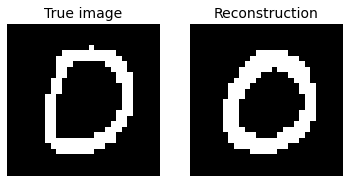

In [148]:
# Verify if there is some learning
fig, ax = plt.subplots(1,2)

test_sample = 10 

# Prediction 
pred = model(x_test_images[test_sample:test_sample+1]).mode()
pred = pred.numpy().squeeze()

ax[0].imshow(x_test_images[test_sample].squeeze(),cmap='gray')
ax[1].imshow(pred,cmap='gray')
ax[0].set_title('True image',fontsize=14)
ax[1].set_title('Reconstruction',fontsize=14);
ax[0].axis('off');
ax[1].axis('off');